# SVMs for orbit classification



In [30]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt 
from imblearn.over_sampling import SMOTE 

## Loading the dataset

In [31]:
# Read in the dataset
pd.set_option('display.max_columns', 50)
df = pd.read_csv('shortenedorbit.csv', low_memory=False)
df = df.drop(['Name', 'Arc_years', 'Number','Computer', 'Last_obs', 'Principal_desig',
              'Other_desigs','Ref', 'Hex_flags', 'U'],axis='columns')

df['Perturbers'] = df['Perturbers'].fillna('No_Coarse')
df['Perturbers_2'] = df['Perturbers_2'].fillna('No_Precise')

df = df.drop(df[df['Orbit_type'] == 'MBA'].sample(frac=.65).index)

possibleLabels = df.Orbit_type.value_counts()
labeldummies = pd.get_dummies(df.Orbit_type)
pert1dummies = pd.get_dummies(df.Perturbers)
pert2dummies = pd.get_dummies(df.Perturbers_2)
df = pd.concat([pert1dummies,pert2dummies,df],axis='columns')

df = df.drop(['Perturbers'],axis='columns')
df = df.drop(['Perturbers_2'],axis='columns')
df = df.fillna(0)
df.head()

,M-h,M-v,No_Coarse,38h,3Eh,3Ek,No_Precise,NEO_flag,One_km_NEO_flag,PHA_flag,H,G,Num_obs,rms,Epoch,M,Peri,Node,i,e,n,a,Num_opps,Tp,Orbital_period,Perihelion_dist,Aphelion_dist,Semilatus_rectum,Synodic_period,Orbit_type
0,0,1,0,1,0,0,0,0.0,0.0,0.0,16.80,0.15,121.0,0.22,2459200.5,347.29934,292.08908,115.44159,3.69920,0.123595,0.184896,3.051533,6,2.459269e+06,5.330613,2.674377,3.428689,1.502459,1.230914,MBA
1,0,1,0,1,0,0,0,0.0,0.0,0.0,16.00,0.15,144.0,0.33,2459200.5,334.72919,35.72789,302.53648,8.37753,0.119916,0.229829,2.639571,9,2.459310e+06,4.288446,2.323043,2.956098,1.300807,1.304095,MBA
2,0,1,0,1,0,0,0,0.0,0.0,0.0,16.80,0.15,171.0,0.32,2459200.5,14.03074,202.06597,152.13493,14.20004,0.221219,0.215091,2.758806,10,2.459135e+06,4.582282,2.148507,3.369106,1.311898,1.279152,MBA
3,0,1,0,1,0,0,0,0.0,0.0,0.0,17.00,0.15,116.0,0.25,2459200.5,226.30053,147.59857,170.66127,13.29714,0.059035,0.220231,2.715714,11,2.459808e+06,4.475341,2.555393,2.876036,1.353125,1.287742,MBA
5,0,1,0,0,0,1,0,0.0,0.0,0.0,17.79,0.15,211.0,0.55,2459200.5,303.21970,180.59257,189.65732,5.43086,0.182016,0.284133,2.291511,10,2.459400e+06,3.468830,1.874419,2.708603,1.107797,1.405050,MBA


All possible orbit classifications

In [32]:
possibleLabels

MBA                                           789
Hungaria                                       54
Object with perihelion distance < 1.665 AU     53
Apollo                                         34
Jupiter Trojan                                 26
Amor                                           24
Hilda                                          19
Phocaea                                        19
Aten                                           10
Distant Object                                  8
Name: Orbit_type, dtype: int64

All features of our dataset (excl. orbit type)

In [20]:
df.dtypes

M-h                   uint8
M-v                   uint8
No_Coarse             uint8
38h                   uint8
3Eh                   uint8
3Ek                   uint8
No_Precise            uint8
NEO_flag            float64
One_km_NEO_flag     float64
PHA_flag            float64
H                   float64
G                   float64
Num_obs             float64
rms                 float64
Epoch               float64
M                   float64
Peri                float64
Node                float64
i                   float64
e                   float64
n                   float64
a                   float64
Num_opps              int64
Tp                  float64
Orbital_period      float64
Perihelion_dist     float64
Aphelion_dist       float64
Semilatus_rectum    float64
Synodic_period      float64
Orbit_type           object
dtype: object

## Preprocessing

### Splitting the data, scaling the data, and label encoding

In [21]:
le = preprocessing.LabelEncoder()
y = df['Orbit_type']
y = le.fit_transform(y)

np.unique(y)
df = df.drop(['Orbit_type'],axis='columns')

In [22]:
X = df.iloc[:,:40].values
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [23]:
print("Shapes of data")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Shapes of data
X_train: (777, 29)
y_train: (777,)
X_test: (259, 29)
y_test: (259,)


## SVM

### Linear Kernel

In [24]:
cvals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000]
kf = KFold(n_splits=10)
# Accuracy
linsvm_training_acc = []
linsvm_test_acc = []

polysvm_training_acc = []
polysvm_test_acc = []

rbfsvm_training_acc = []
rbfsvm_test_acc = []

# Precision
linsvm_test_prec = []
polysvm_test_prec = []
rbfsvm_test_prec = []

# Recall
linsvm_test_recall = []
polysvm_test_recall = []
rbfsvm_test_recall = []

# F1 Score
linsvm_test_f1 = []
polysvm_test_f1 = []
rbfsvm_test_f1 = []

# Weights
linsvm_weights = []

In [25]:
def runallsvm(cval):
    linearsvm = SVC(kernel='linear', probability=False, C=cval)
    polysvm = SVC(kernel='poly', probability=False, C=cval)
    rbfsvm = SVC(kernel='rbf', probability=False, C=cval)
    
    linprec = []
    polyprec = []
    rbfprec = []
    
    linrec = []
    polyrec = []
    rbfrec = []
    
    linf1 = []
    polyf1 = []
    rbff1 = []
    
    lintrainacc = []
    polytrainacc =[]
    rbftrainacc = []
    
    lintestacc = []
    polytestacc = []
    rbftestacc = []

    for train, test in kf.split(X_train):
        X_tr = X_train[train,:]
        y_tr = y_train[train]
        X_ts = X_train[test,:]
        y_ts = y_train[test]
        
        X_tr = preprocessing.scale(X_tr)
        X_ts = preprocessing.scale(X_ts)
        
        sm = SMOTE(k_neighbors=2)
        X_tr_smt, y_tr_smt = sm.fit_resample(X_tr, y_tr)
        
        # Linear
        linearsvm.fit(X_tr_smt,y_tr_smt)
        lin_yhat_train = linearsvm.predict(X_tr_smt)
        lin_yhat_test = linearsvm.predict(X_ts) 
 
        lin_fold_trainacc = np.mean(lin_yhat_train == y_tr_smt)
        lin_fold_testacc = np.mean(lin_yhat_test == y_ts)
        
        lin_fold_precision,lin_fold_recall,lin_fold_f1score,_= precision_recall_fscore_support(y_ts,lin_yhat_test,average='weighted') 
        
        linprec.append(lin_fold_precision)
        linrec.append(lin_fold_recall)
        linf1.append(lin_fold_f1score)
        lintrainacc.append(lin_fold_trainacc)
        lintestacc.append(lin_fold_testacc)
        
        # Poly
        polysvm.fit(X_tr_smt,y_tr_smt)
        poly_yhat_train = polysvm.predict(X_tr_smt)
        poly_yhat_test = polysvm.predict(X_ts) 
        
        poly_fold_trainacc = np.mean(poly_yhat_train == y_tr_smt)
        poly_fold_testacc = np.mean(poly_yhat_test == y_ts)
        
        poly_fold_precision,poly_fold_recall,poly_fold_f1score,_= precision_recall_fscore_support(y_ts,poly_yhat_test,average='weighted') 
        
        polyprec.append(poly_fold_precision)
        polyrec.append(poly_fold_recall)
        polyf1.append(poly_fold_f1score)
        polytrainacc.append(poly_fold_trainacc)
        polytestacc.append(poly_fold_testacc)


        # RBF
        rbfsvm.fit(X_tr_smt,y_tr_smt)
        rbf_yhat_train = rbfsvm.predict(X_tr_smt)
        rbf_yhat_test = rbfsvm.predict(X_ts) 

        rbf_fold_trainacc = np.mean(rbf_yhat_train == y_tr_smt)
        rbf_fold_testacc = np.mean(rbf_yhat_test == y_ts)
        
        rbf_fold_precision,rbf_fold_recall,rbf_fold_f1score,_= precision_recall_fscore_support(y_ts,rbf_yhat_test,average='weighted') 
        
        rbfprec.append(rbf_fold_precision)
        rbfrec.append(rbf_fold_recall)
        rbff1.append(rbf_fold_f1score)
        rbftrainacc.append(rbf_fold_trainacc)
        rbftestacc.append(rbf_fold_testacc)
        
        
    linsvm_weights.append(linearsvm.coef_)           
    linsvm_training_acc.append(np.mean(lintrainacc))
    linsvm_test_acc.append(np.mean(lintestacc))
    linsvm_test_prec.append(np.mean(linprec))
    linsvm_test_recall.append(np.mean(linrec))
    linsvm_test_f1.append(np.mean(linf1))
    
    polysvm_training_acc.append(np.mean(polytrainacc))
    polysvm_test_acc.append(np.mean(polytestacc))
    polysvm_test_prec.append(np.mean(polyprec))
    polysvm_test_recall.append(np.mean(polyrec))
    polysvm_test_f1.append(np.mean(polyf1))  
    
    rbfsvm_training_acc.append(np.mean(rbftrainacc))
    rbfsvm_test_acc.append(np.mean(rbftestacc))
    rbfsvm_test_prec.append(np.mean(rbfprec))
    rbfsvm_test_recall.append(np.mean(rbfrec))
    rbfsvm_test_f1.append(np.mean(rbff1))  

In [26]:
for c in cvals:
    runallsvm(c)

C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packa

C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metr

C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\skle

C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packa

C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metr

C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\skle

C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\skle

C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packa

C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\skle

C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\skle

C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andromeda\anaconda3\lib\site-packages\sklearn\metr

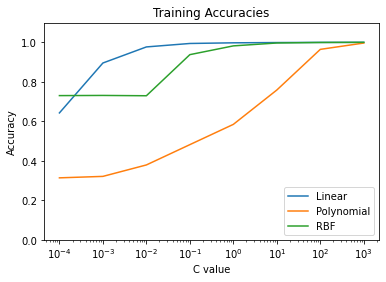

In [27]:
plt.title("Training Accuracies") 
plt.xlabel("C value") 
plt.ylabel("Accuracy") 
plt.yscale('linear')
plt.xscale('log')
plt.plot(cvals,linsvm_training_acc) 
plt.plot(cvals,polysvm_training_acc) 
plt.plot(cvals,rbfsvm_training_acc) 
plt.gca().set_ylim([0,1.1])
plt.legend(['Linear', 'Polynomial', 'RBF'], loc='lower right')
plt.savefig('SVM_trainings.png')
plt.show()

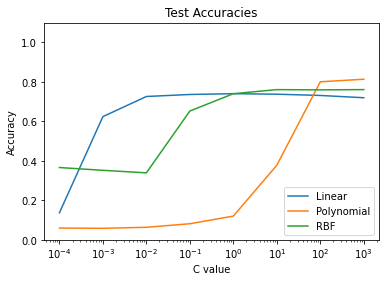

In [28]:
plt.title("Test Accuracies") 
plt.xlabel("C value") 
plt.ylabel("Accuracy") 
plt.yscale('linear')
plt.xscale('log')
plt.plot(cvals,linsvm_test_acc) 
plt.plot(cvals,polysvm_test_acc) 
plt.plot(cvals,rbfsvm_test_acc) 
plt.gca().set_ylim([0,1.1])
plt.legend(['Linear', 'Polynomial', 'RBF'], loc='lower right')
plt.savefig('SVM_tests.png')
plt.show()

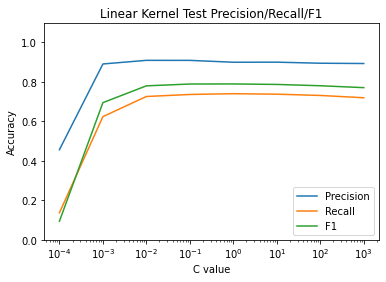

In [29]:
plt.title("Linear Kernel Test Precision/Recall/F1") 
plt.xlabel("C value") 
plt.ylabel("Accuracy") 
plt.yscale('linear')
plt.xscale('log')
plt.plot(cvals,linsvm_test_prec) 
plt.plot(cvals,linsvm_test_recall) 
plt.plot(cvals,linsvm_test_f1) 
plt.gca().set_ylim([0,1.1])
plt.legend(['Precision', 'Recall', 'F1'], loc='lower right')
plt.savefig('SVM_Linear_Test_PRF.png')
plt.show()

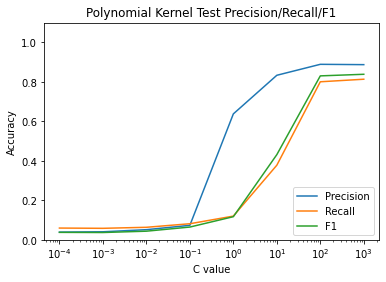

In [30]:
plt.title("Polynomial Kernel Test Precision/Recall/F1") 
plt.xlabel("C value") 
plt.ylabel("Accuracy") 
plt.yscale('linear')
plt.xscale('log')
plt.plot(cvals,polysvm_test_prec) 
plt.plot(cvals,polysvm_test_recall) 
plt.plot(cvals,polysvm_test_f1) 
plt.gca().set_ylim([0,1.1])
plt.legend(['Precision', 'Recall', 'F1'], loc='lower right')
plt.savefig('SVM_Poly_Test_PRF.png')
plt.show()

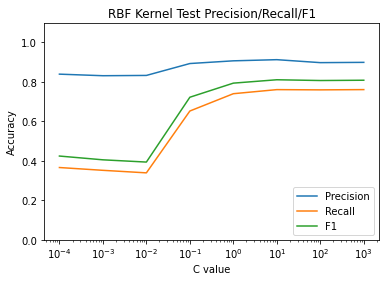

In [31]:
plt.title("RBF Kernel Test Precision/Recall/F1") 
plt.xlabel("C value") 
plt.ylabel("Accuracy") 
plt.yscale('linear')
plt.xscale('log')
plt.plot(cvals,rbfsvm_test_prec) 
plt.plot(cvals,rbfsvm_test_recall) 
plt.plot(cvals,rbfsvm_test_f1) 
plt.gca().set_ylim([0,1.1])
plt.legend(['Precision', 'Recall', 'F1'], loc='lower right')
plt.savefig('SVM_RBF_Test_PRF.png')
plt.show()

In [32]:
linsvm_test_acc

[0.1375957375957376,
 0.6242091242091242,
 0.7259240759240759,
 0.7361971361971361,
 0.7401431901431902,
 0.7376123876123877,
 0.7312187812187813,
 0.7196636696636697]

In [33]:
polysvm_test_acc

[0.060389610389610396,
 0.059124209124209126,
 0.06426906426906427,
 0.08226773226773228,
 0.12094572094572094,
 0.37830502830502827,
 0.8004162504162504,
 0.8133366633366634]

In [34]:
rbfsvm_test_acc

[0.36663336663336665,
 0.3525141525141525,
 0.3396603396603396,
 0.6524975024975025,
 0.7400765900765901,
 0.7607392607392607,
 0.7595238095238095,
 0.7608225108225108]